# Лабораторная работа №5. Автокорреляция

### Лодочникова Владлена. Группа №5130901/10202

### Упражнение 5.1 

Блокнот Jupyter этой главы, chap05.ipynb, содержить приложение, в котором можно вычислить автокорреляцию для различных lag. Оценим высоты тона вокального чирпа для нескольких времен начала сегмента. 


In [1]:
import numpy as np

def serial_corr(wave, lag=1):
    n = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:n-lag]
    corr_mat = np.corrcoef(y1, y2)
    return corr_mat[0, 1]

In [2]:
def autocorr(wave):
    lags = np.arange(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

In [3]:
from thinkdsp import read_wave
wave = read_wave('87778__marcgascon7__vocals.wav')
wave.make_audio()

In [4]:
wave1 = wave.segment(start = 3, duration = 1) 
wave1.make_audio()

In [5]:
wave2 = wave.segment(start = 5, duration = 1) 
wave2.make_audio()

Вычислим автокорреляцию сначала звука "И", а потом звука "О". 

In [6]:
lags, corrs = autocorr(wave1)

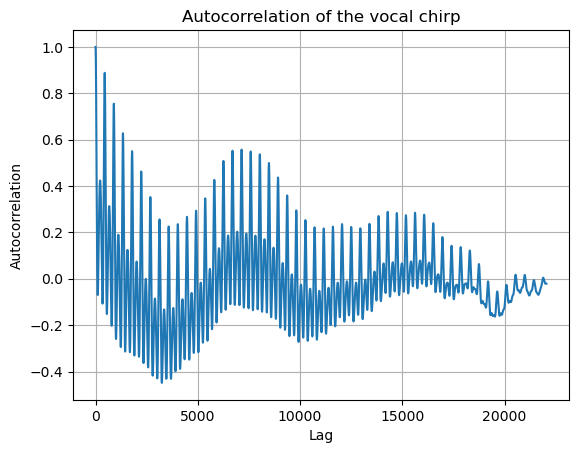

In [7]:
import matplotlib.pyplot as plt

plt.plot(lags, corrs)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of the vocal chirp')
plt.grid(True)
plt.show()

In [8]:
lags1, corrs1 = autocorr(wave2)

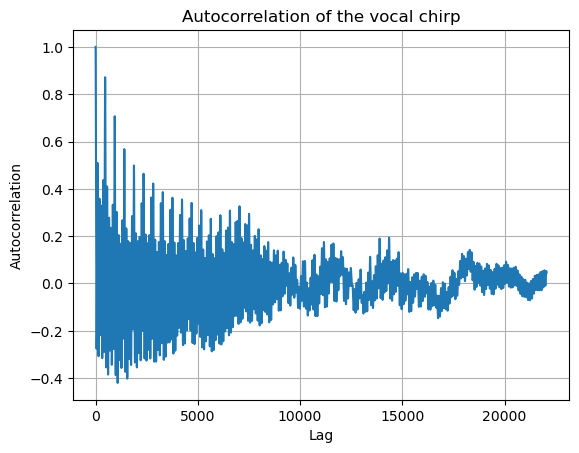

In [9]:
plt.plot(lags1, corrs1)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of the vocal chirp')
plt.grid(True)
plt.show()

Для примеров были взяты звуки "И" и "О". Видно, что на графике со звуком "И"  представлена звуковая волна, в кторой частота постепенно изменяется с течением времени. Такое может произойти при произнесении определенных звуков, когда человеческие голосовые связки переходяь от одного резонансного состояния к другому. На графике со звуком "О" этого не видно. 

### Упражнение 5.2

Пример кода в chap05.ipynb показывает, как использывать автокорреляцию для оценки основной частоты периодического синала.

Инкапсулируем этот код в функцию, названную estimate_fundamental, и используем ее для отслеживания высоты тона записанного звука. 

Возьмем звук из уже имеющегося списка в папке проекта ThinkDSP. 

In [10]:
from thinkdsp import read_wave

wave = read_wave('28042__bcjordan__voicedownbew.wav')
wave.normalize()
wave.make_audio()

Создадим спектограмму. 


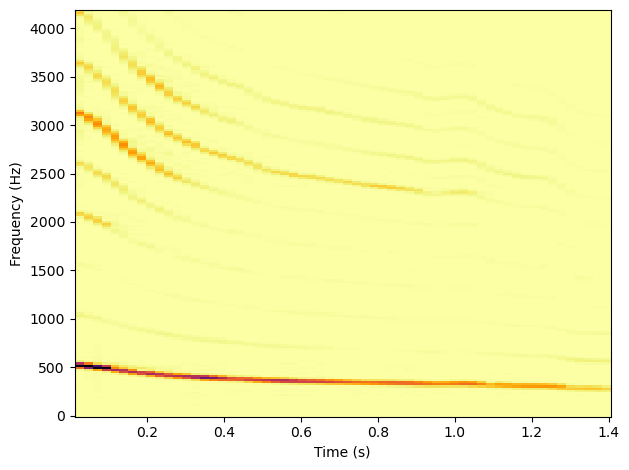

In [11]:
from thinkdsp import decorate

wave.make_spectrogram(2048).plot(high=4200)
decorate(xlabel='Time (s)', 
         ylabel='Frequency (Hz)')

Напишем функцию estimate_fundamental. 

In [12]:
def estimate_fundamental(segment, low=70, high=150):
    lags, corrs = autocorr(segment)
    lag = np.array(corrs[low:high]).argmax() + low
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

Далее можем посмотреть, как она работает. 

In [13]:
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)
freq = estimate_fundamental(segment)
freq

436.63366336633663

Результат получился 436.63366336633663.

Далее в коде ts - это середина каждого сегмента.

In [14]:
step = 0.05
starts = np.arange(0.0, 1.4, step)

ts = []
freqs = []

for start in starts:
    ts.append(start + step/2)
    segment = wave.segment(start=start, duration=duration)
    freq = estimate_fundamental(segment)
    freqs.append(freq)

Ниже будет представлена кривая отслеживания высоты тона, наложенная на спектрограмму. Это означает, что на изображении можно увидеть изменение высоты тона во времени, а также соответствующее изменение спектра частот. Это может быть полезно для анализа звуковых сигналов, таких как речь или музыка.

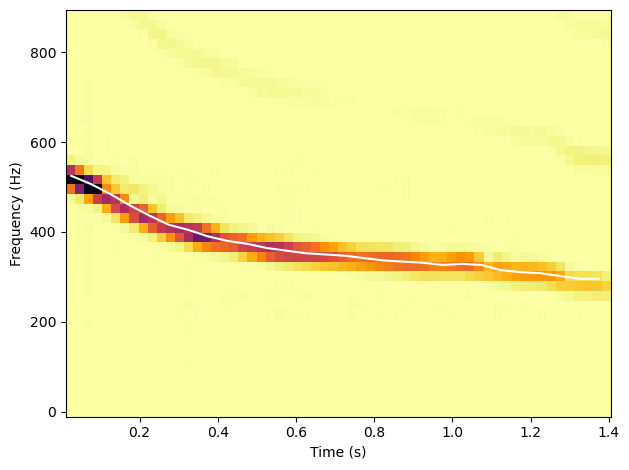

In [15]:
wave.make_spectrogram(2048).plot(high=900)
plt.plot(ts, freqs, color='white')
decorate(xlabel='Time (s)', 
                     ylabel='Frequency (Hz)')

Убедились, что работает хорошо. 

### Упражнение 5.3

Используя исторические данные BitCoin вычисли автокорреляции цен в платежной системе BitCoin. Быстро ли спадает автокорреляционная функция? Есть ли признаки периодичности процесса? Используем исторические данные из уже имеющихся данных в папке проекта ThinkDSP.

Сначала создадим pandas dataframe на основе данных. 

In [16]:
import pandas as pd

df = pd.read_csv('BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv', 
                 parse_dates=[0])

ys = df['Closing Price (USD)']
ts = df.index

Распечатаем график цены биткоина.

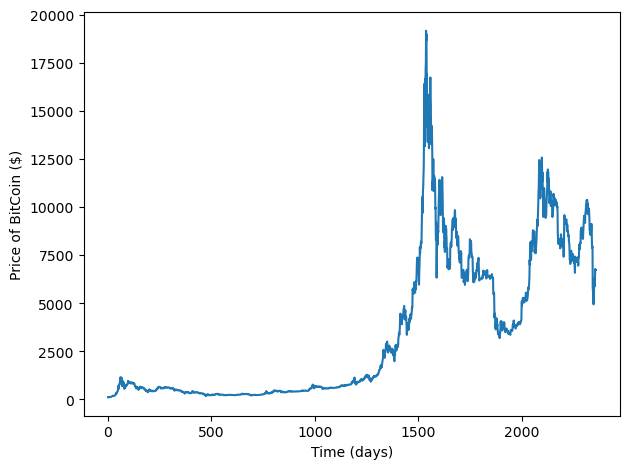

In [17]:
from thinkdsp import Wave

wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Time (days)',
         ylabel='Price of BitCoin ($)')

Используя функции serial_corr и autocorr выполним график автокорреляции. 

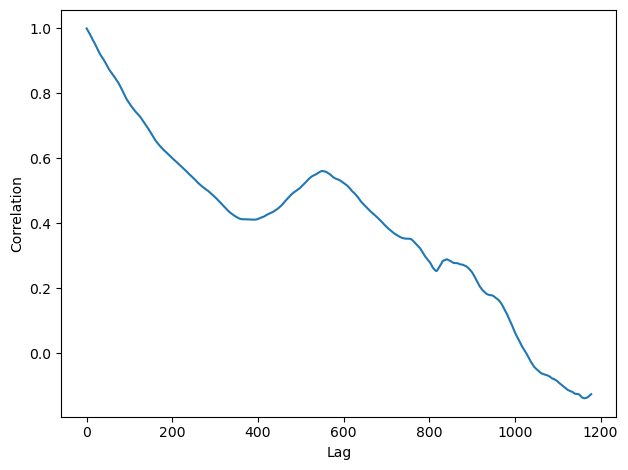

In [23]:
result = autocorr(wave)
lags, corrs = result
plt.plot(lags, corrs)
decorate(xlabel='Lag',
         ylabel='Correlation')

График демонстрирует постепенное снижение, которое напоминает розовый шум. Есть корреляция при lag = 500. 

Теперь вычислим корреляцию на основе функции np.correlate. Она не смещает и не нормализует волну.

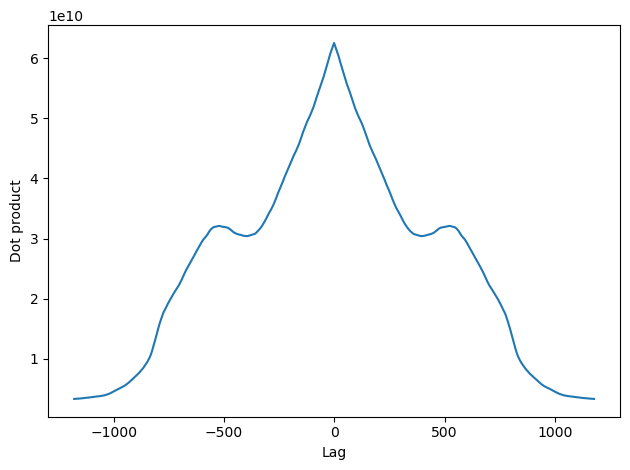

In [26]:
corrs2 = np.correlate(wave.ys, wave.ys, mode='same')
lags = np.arange(-len(wave) // 2, len(wave) // 2) 
plt.plot(lags, corrs2)
decorate(xlabel='Lag',
         ylabel='Dot product')

Вторая половина результатов соответствует интервалам задержек с положительными значениями. Рассмотрим ее подробнее. 

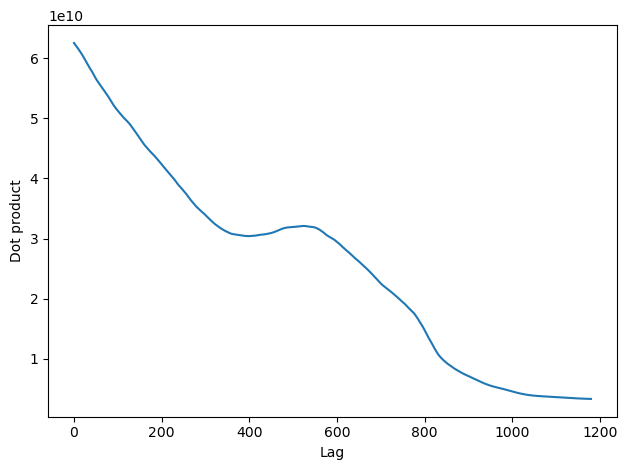

In [27]:
N = len(corrs2)
half = corrs2[N//2:]
plt.plot(half)
decorate(xlabel='Lag',
         ylabel='Dot product')

Теперь сделаем, чтобы разметка графика была одинаковой. 

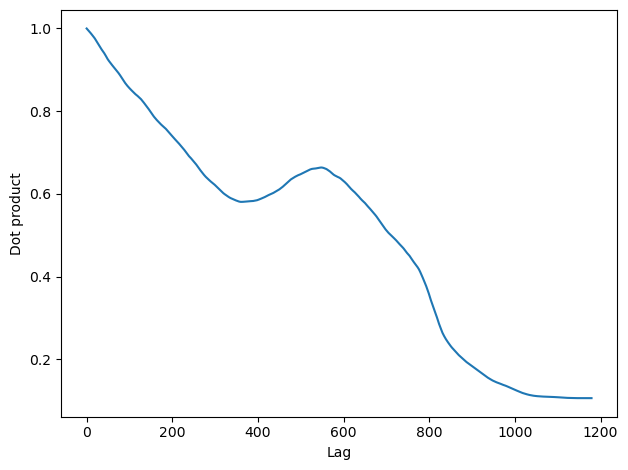

In [30]:
lengths = range(N, N//2, -1)
half /= lengths
half /= half[0]
plt.plot(half)
decorate(xlabel='Lag',
         ylabel='Dot product')

Теперь мы можем сравнить их.

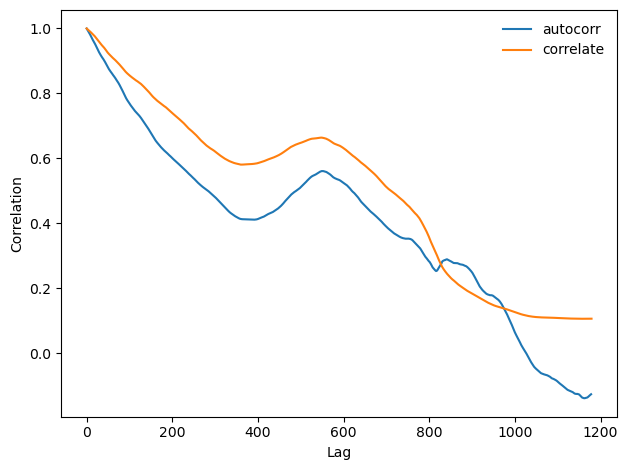

In [31]:
plt.plot(corrs, label='autocorr')
plt.plot(half, label='correlate')
decorate(xlabel='Lag', ylabel='Correlation')

Из графика видно, что функция autocorr более точная, чем функция correlate. Признаков периодичности нет. Автокорреляционная функция спадает постепенно. 